In [1]:
import numpy as np
import ray
import matplotlib.pyplot as plt
import time
from utils import *
from procedures import *
plt.rcParams["font.sans-serif"] = "DejaVu Sans"
plt.rcParams["mathtext.default"]  = "it"
plt.rcParams["mathtext.fontset"]  = "dejavusans"

In [2]:
def gamma_shrink1(delta, n_alternatives):
    return delta/(n_alternatives)


def gamma_shrink2(delta, n_alternatives):
    return delta/np.sqrt(n_alternatives)

    
def good_count1(k, const=0.1):
    #k >= 3/const
    n = np.max([const*k, 2])
    return int(n)

def good_count2(k, const=0.1):
    #k >= 9/const^2
    n = np.max([const*np.sqrt(k), 2])
    return int(n)

In [3]:
# define problem configurations used in EC.3.6.2

class ExplicitMeanGenerator(object):
    def __init__(self, n_alternatives, delta, gamma_shrink, good_count, alternatives_var, const=0.1):
        self.n_alternatives = n_alternatives
        self.best_mean = delta
        self.second_best_mean = delta - gamma_shrink(delta, n_alternatives)
        n_goods = good_count(n_alternatives, const)
        if n_goods >= 3:
            good_means = np.random.uniform(0, self.second_best_mean, n_goods-2)
        else:
            good_means = np.array([])
        bad_means = np.random.uniform(-1, 0, n_alternatives-n_goods)
        _temp = np.array([self.best_mean, self.second_best_mean])
        self.means = np.concatenate([_temp, good_means, bad_means])
        self.best = np.argmax(self.means)
        self.gamma = self.best_mean - self.second_best_mean
        self.variances = np.ones(self.n_alternatives)*alternatives_var
        self.stds = np.sqrt(self.variances)
        
    def get(self, index, n=1):
        return np.random.normal(self.means[index], self.stds[index], n)
        
    def syscount(self):
        return self.n_alternatives

In [4]:
num_cpus=96
ray.shutdown()
ray.init(num_cpus=num_cpus, ignore_reinit_error=True)

2023-08-04 18:15:59,797	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.15
Ray version:,2.2.0
Dashboard:,http://127.0.0.1:8265


In [5]:
n_replications = 2000
 
min_power = 8
max_power = 17
base = 2

alternatives_var = 1

delta = 0.05

In [6]:
seed = 2023080405
np.random.seed(seed)
rng = np.random.default_rng(seed)

EFG1_results = []
EFG2_results = []

n = 100
greedy_ratio = 0.1

const1 = 0.05
const3 = 0.5

for power in np.arange(min_power, max_power+1):
        generators = [ExplicitMeanGenerator(2**power, delta, gamma_shrink1, 
                                            good_count1, alternatives_var, const1) for i in range(n_replications)]


        ng = int(greedy_ratio*n)
        n0 = n-ng

        print("EFG good count 1")
        PCS, PGS = parallel_experiments(rng,  generators, policy=EFG, delta=delta, remote_policy=remote_EFG, 
                                        args={"n0":n0, "ng":ng})
        EFG1_results.append([PCS,PGS])

        generators = [ExplicitMeanGenerator(2**power, delta, gamma_shrink1, 
                                            good_count2, alternatives_var, const3) for i in range(n_replications)]


        print("EFG good count 2")
        PCS, PGS = parallel_experiments(rng,  generators, policy=EFG, delta=delta, remote_policy=remote_EFG, 
                                        args={"n0":n0, "ng":ng})
        EFG2_results.append([PCS,PGS])

EFG good count 1
--------New experiments with  k=256----------------------
Start to simulate... at Fri Aug  4 18:16:09 2023
PCS:0.146, PGS:0.897
Total time used: 3.2335262298583984s, simulation ends at Fri Aug  4 18:16:09 2023
EFG good count 2
--------New experiments with  k=256----------------------
Start to simulate... at Fri Aug  4 18:16:13 2023
PCS:0.18, PGS:0.857
Total time used: 3.076211452484131s, simulation ends at Fri Aug  4 18:16:13 2023
EFG good count 1
--------New experiments with  k=512----------------------
Start to simulate... at Fri Aug  4 18:16:16 2023
PCS:0.098, PGS:0.934
Total time used: 3.2674355506896973s, simulation ends at Fri Aug  4 18:16:16 2023
EFG good count 2
--------New experiments with  k=512----------------------
Start to simulate... at Fri Aug  4 18:16:19 2023
PCS:0.1625, PGS:0.8705
Total time used: 3.280158281326294s, simulation ends at Fri Aug  4 18:16:19 2023
EFG good count 1
--------New experiments with  k=1024----------------------
Start to simulate

In [ ]:
EFG1_results

In [ ]:
EFG2_results

In [19]:
# results drawn from the above experiments for producing the Figure EC14

# EFG1_results = [[0.146, 0.897],
#  [0.098, 0.934],
#  [0.053, 0.9285],
#  [0.0335, 0.946],
#  [0.0265, 0.962],
#  [0.018, 0.964],
#  [0.009, 0.96],
#  [0.004, 0.9645],
#  [0.0035, 0.962],
#  [0.004, 0.9645]]

# EFG2_results = [[0.18, 0.857],
#  [0.1625, 0.8705],
#  [0.1435, 0.9325],
#  [0.141, 0.9575],
#  [0.1115, 0.9805],
#  [0.108, 0.9875],
#  [0.099, 0.9965],
#  [0.0725, 0.998],
#  [0.059, 0.9985],
#  [0.051, 1.0]]

In [20]:
np.array(EFG1_results).T, np.array(EFG2_results).T

(array([[0.146 , 0.098 , 0.053 , 0.0335, 0.0265, 0.018 , 0.009 , 0.004 ,
         0.0035, 0.004 ],
        [0.897 , 0.934 , 0.9285, 0.946 , 0.962 , 0.964 , 0.96  , 0.9645,
         0.962 , 0.9645]]),
 array([[0.18  , 0.1625, 0.1435, 0.141 , 0.1115, 0.108 , 0.099 , 0.0725,
         0.059 , 0.051 ],
        [0.857 , 0.8705, 0.9325, 0.9575, 0.9805, 0.9875, 0.9965, 0.998 ,
         0.9985, 1.    ]]))

In [21]:
results_list = [
    np.array(EFG1_results).T[1], np.array(EFG2_results).T[1]]

In [22]:
results_list

[array([0.897 , 0.934 , 0.9285, 0.946 , 0.962 , 0.964 , 0.96  , 0.9645,
        0.962 , 0.9645]),
 array([0.857 , 0.8705, 0.9325, 0.9575, 0.9805, 0.9875, 0.9965, 0.998 ,
        0.9985, 1.    ])]

[array([0.897 , 0.934 , 0.9285, 0.946 , 0.962 , 0.964 , 0.96  , 0.9645,
       0.962 , 0.9645]), array([0.857 , 0.8705, 0.9325, 0.9575, 0.9805, 0.9875, 0.9965, 0.998 ,
       0.9985, 1.    ])]


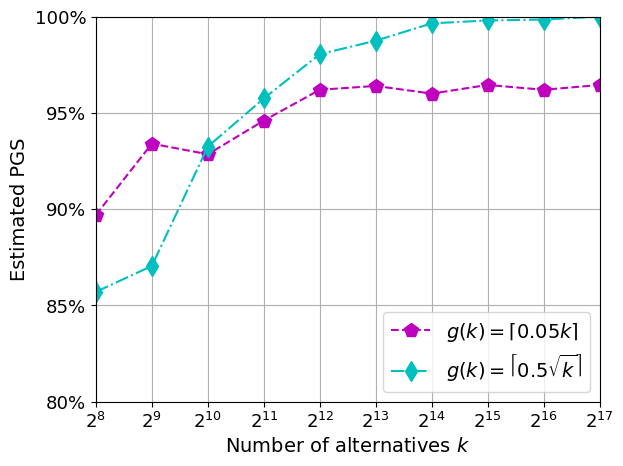

In [23]:
fontsize= 14
powers = np.arange(min_power, max_power+1)
colors = ["m","c", "k", "b", "r"]
markers = ["p", "d", "o"]
line_styles = ["--", "-.", ":","--", "-.", "--", '-.']

titles = ["$\gamma(k)=\\frac{0.05}{k}$"]
fig = plt.figure(figsize=(6.5, 5))

gap = 0.10

fig_plots = [(1,1,1)]

labels = ["$g(k) =  \\left\\lceil 0.05k \\right\\rceil$", 
          "$g(k) =  \\left\\lceil 0.5 \sqrt{k} \\right\\rceil$"]


for i, fig_plot in enumerate(fig_plots):
    
    ax = fig.add_subplot(*fig_plots[i])
    
    results = results_list
    print(results)

    for j, result in enumerate(results):
        plt.plot(powers, result, line_styles[j], markersize=10, color=colors[j], marker=markers[j], label=labels[j])
    
    
    plt.xlim(min_power, max_power)
    xticks = powers
    xticklabels = ["2^{"+str(power)+"}" for power in xticks]
    xticklabels = ["$"+power_label+"$" for power_label in xticklabels]
    plt.xticks(xticks, xticklabels, fontsize=fontsize-1)
    
    if i == 0:
        ax.legend(prop={'family': 'serif',"size":fontsize}, loc="lower right")
        plt.ylim(0.8, 1.0)
        yticks = np.arange(0.8, 1.05, 0.05)
        yticklabels = ["%.0f"%(tick*100)+"%" for tick in yticks]
        plt.yticks(yticks, yticklabels, fontsize=fontsize-1) 

    
    ax.set_xlabel("Number of alternatives $k$", size=fontsize)
    if i == 0 or i == 2:
        ax.set_ylabel("Estimated PGS", size=fontsize)
    if i == 1:
        ax.set_ylabel("Estimated PGS", size=fontsize, labelpad=0)
#     plt.title(titles[i], fontsize=fontsize)
    plt.grid(0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.25, hspace=None)

plt.show()

fig.savefig("Figure_EC14.pdf", bbox_inches='tight')